In [104]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm



import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

Mappa originale in 1D -> Q_40

Mappa con patch originale 2D -> maps_2d['mp_hp_Q40']

Mappa (patch) con beam 2D -> Q_conv_real_40

Mappa (patch) con beam + angle 2D -> Q_polangle_40

Mappa (patch) con beam + angle + ap 2D -> Q_ap_40

Mappa (patch) con beam + angle + ap 1D -> flatten_maps['Q_flat40']

CMB (patch) con beam + angle + ap 1D -> cmb_I

CMB (patch) con beam + angle + ap 2D -> cmb_I_2d

CMB (patch) deconvoluta 2D -> I_deconv

In [105]:
nside = 64

sky = get_sky(nside, 'd1s1')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)

In [106]:
pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


In [107]:
# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

(49152,)

# Creazione patch

In [108]:
def create_rectangular_patch(RA_limits, DEC_limits, nside, fact = 3):

    '''
    Create a rectangular patch in a healpix map
    Parameters:
    RA_limits: array or list with the edges of the map along the RA axis
    DEC_limits: array or list with the edges of the map along the DEC axis
    nside: nside of the map
    fact: just a factor to increase the resolution to be sure all the pixels in patch
          are extracted
    '''

    resol = (hp.nside2resol(nside, arcmin=True) / 60.) / fact

    RA = np.radians(np.arange(RA_limits[0], RA_limits[1] + resol, resol))
    DEC = np.radians(np.arange(DEC_limits[0], DEC_limits[1] + resol, resol))
    
    DEC = 0.5 * np.pi - DEC
    
    theta, phi = np.meshgrid(RA, DEC)

    idx = hp.ang2pix(nside, phi, theta)

    return np.unique(idx), resol * fact

In [109]:
# patch
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40
idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)

In [110]:
map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0

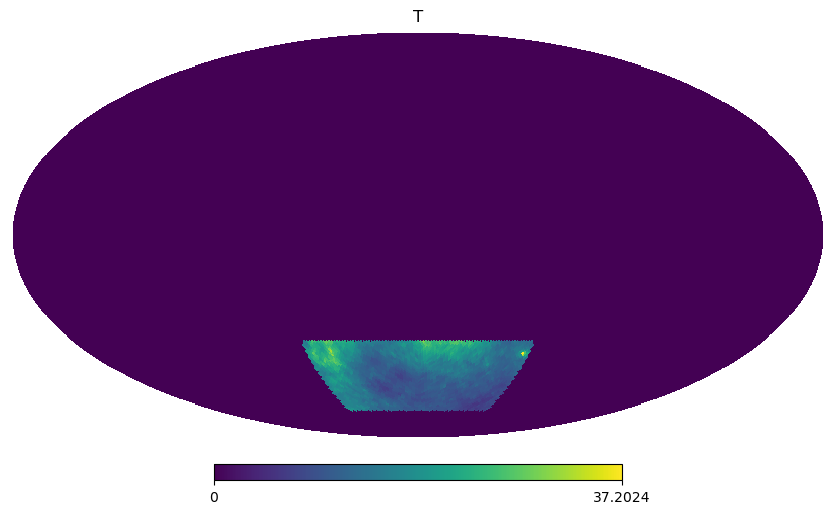

In [111]:
hp.mollview(I40, title='T')

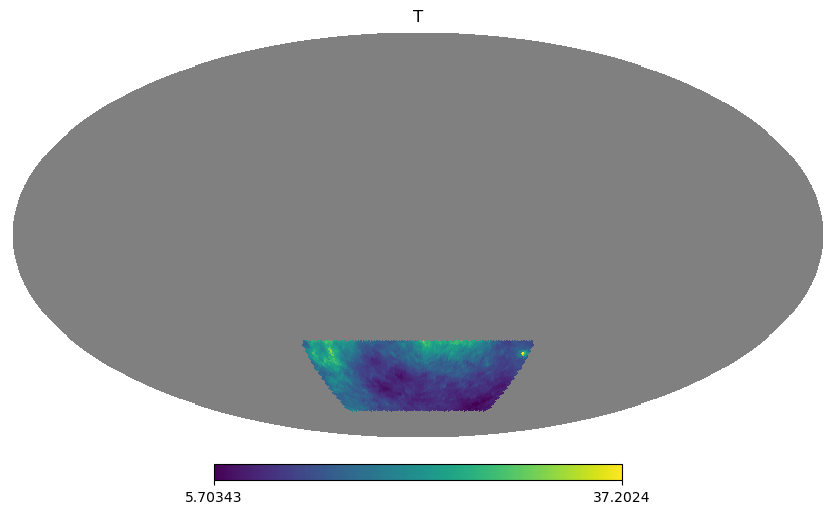

In [112]:
# creo una copia di una e uso hp.UNSEEN per la visualizzazione

I_map2 = np.array(I40)

for i in range(len(I_map2)):
    if I_map2[i] == 0:
        I_map2[i] = hp.UNSEEN
        
hp.mollview(I_map2, title='T')

### Conversion 1D -> 2D

In [113]:
from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

In [114]:
def convert2grid(map, nside, resol, RA, DEC, method='healpy', scipy_method='linear', fill_nan=True):

    xsize = int(np.ceil(np.abs(np.ptp(RA))/resol))
    ysize = int(np.ceil(np.abs(np.ptp(DEC))/resol))

    if method == 'healpy':
        proj = hp.projector.CartesianProj(
            lonra=[RA1, RA2], latra=[dec1, dec2],
            coord='G',
            xsize=xsize, ysize=ysize)

        reproj_map = np.flip(
            (proj.projmap(map, vec2pix_func=partial(hp.vec2pix, nside))),
            axis=1)

        extent = proj.get_extent()

        ra = np.linspace(extent[0], extent[1], xsize)
        dec = np.linspace(extent[2], extent[3], ysize)

        ra, dec = np.meshgrid(ra, dec)
        
        reproj_map[reproj_map==0]=np.nan

    elif method == 'scipy':
        
        npix = hp.nside2npix(nside)

        ra_full, dec_full = hp.pix2ang(
            nside,
            np.arange(npix),
            lonlat = True
        )

        ra_full[ra_full > 180] -= 360

        idxs, = np.where(map != 0)

        ra, dec = hp.pix2ang(nside, idxs, lonlat=True)

        ra[ra > 180] -= 360

        ra_in = np.arange(np.amin(ra), np.amax(ra)+resol, resol)
        dec_in = np.arange(np.amin(dec), np.amax(dec)+resol, resol)

        ra, dec = np.meshgrid(ra_in, dec_in)

        reproj_map = griddata((ra_full, dec_full), map, (ra, dec), method=scipy_method)

    if fill_nan:
        reproj_map = inpaint.inpaint_biharmonic(reproj_map, np.isnan(reproj_map))

    return reproj_map, ra.flatten(), dec.flatten()

In [115]:
maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']


for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}{band}"
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        #print(f"Stored variables for: {variable_prefix}") 


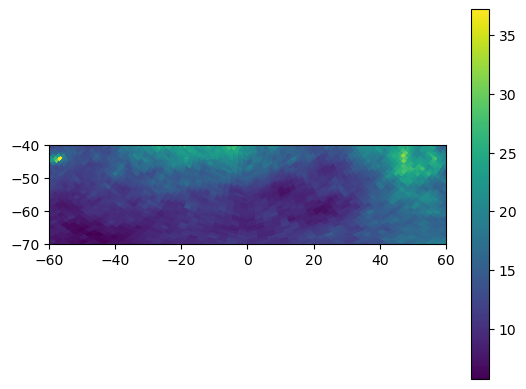

In [116]:
plt.figure()
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()


In [117]:
fits.writeto("patch2d/patch2d_I40", maps_2d['mp_hp_I40'], overwrite=True)
fits.writeto("patch2d/patch2d_Q40", maps_2d['mp_hp_Q40'], overwrite=True)
fits.writeto("patch2d/patch2d_U40", maps_2d['mp_hp_U40'], overwrite=True)

fits.writeto("patch2d/patch2d_I60", maps_2d['mp_hp_I60'], overwrite=True)
fits.writeto("patch2d/patch2d_Q60", maps_2d['mp_hp_Q60'], overwrite=True)
fits.writeto("patch2d/patch2d_U60", maps_2d['mp_hp_U60'], overwrite=True)

fits.writeto("patch2d/patch2d_I78", maps_2d['mp_hp_I78'], overwrite=True)
fits.writeto("patch2d/patch2d_Q78", maps_2d['mp_hp_Q78'], overwrite=True)
fits.writeto("patch2d/patch2d_U78", maps_2d['mp_hp_U78'], overwrite=True)

fits.writeto("patch2d/patch2d_I100", maps_2d['mp_hp_I100'], overwrite=True)
fits.writeto("patch2d/patch2d_Q100", maps_2d['mp_hp_Q100'], overwrite=True)
fits.writeto("patch2d/patch2d_U100", maps_2d['mp_hp_U100'], overwrite=True)

fits.writeto("patch2d/patch2d_I140", maps_2d['mp_hp_I140'], overwrite=True)
fits.writeto("patch2d/patch2d_Q140", maps_2d['mp_hp_Q140'], overwrite=True)
fits.writeto("patch2d/patch2d_U140", maps_2d['mp_hp_U140'], overwrite=True)

fits.writeto("patch2d/patch2d_I195", maps_2d['mp_hp_I195'], overwrite=True)
fits.writeto("patch2d/patch2d_Q195", maps_2d['mp_hp_Q195'], overwrite=True)
fits.writeto("patch2d/patch2d_U195", maps_2d['mp_hp_U195'], overwrite=True)

fits.writeto("patch2d/patch2d_I280", maps_2d['mp_hp_I280'], overwrite=True)
fits.writeto("patch2d/patch2d_Q280", maps_2d['mp_hp_Q280'], overwrite=True)
fits.writeto("patch2d/patch2d_U280", maps_2d['mp_hp_U280'], overwrite=True)

fits.writeto("patch2d/patch2d_I402", maps_2d['mp_hp_I402'], overwrite=True)
fits.writeto("patch2d/patch2d_Q402", maps_2d['mp_hp_Q402'], overwrite=True)
fits.writeto("patch2d/patch2d_U402", maps_2d['mp_hp_U402'], overwrite=True)

# DIMENSIONI MAPPE

In [118]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  

393 99


# Beam

ellipticity =  -0.2


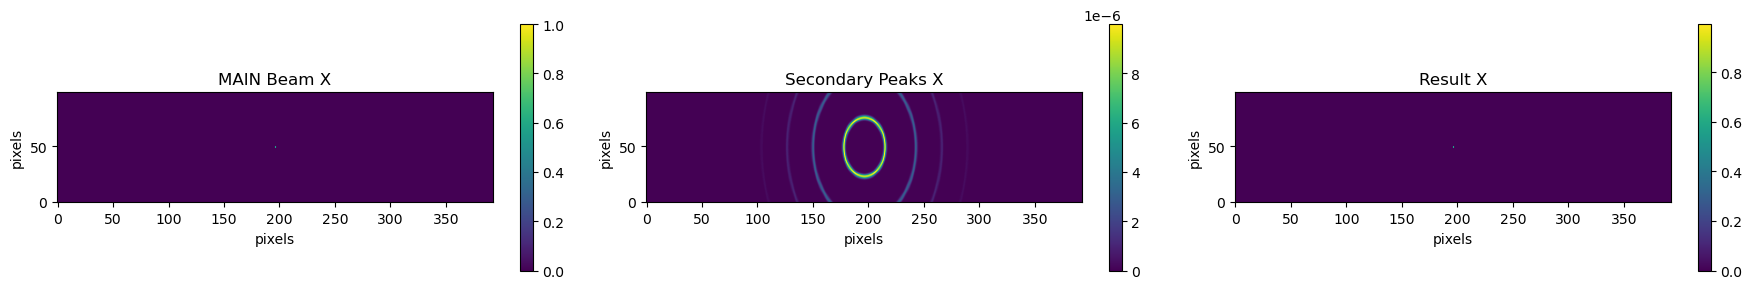

In [119]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

#X = np.outer(onesy, indsx)
#Y = np.outer(indsy, onesx)
X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 40  #degrees
FWHM_y = 60  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([80000, 200000, 300000, 400000]) #angular distance of the peaks
r = 100 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

# PLOT

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
titles = ['MAIN Beam X', 'Secondary Peaks X', 'Result X']
data_list = [beam_gauss_x, sec_rings_x, beam_x]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    cbar = plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

beam max: 4.342923104481638e-05 beam min: 0.8219591069514898


0

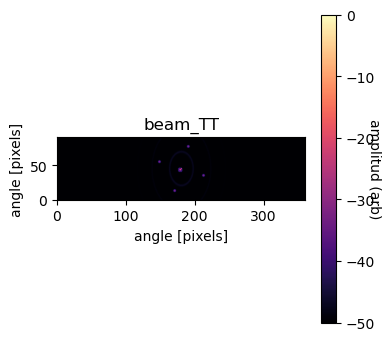

In [120]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":105.5,"R":2000.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


######################################################################################################################################
beam_to_plot = beam_TT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width, Y_width,  "beam_TT", 'angle [pixels]')

In [121]:
output_vars['mp_hp_I40']

# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], perf_beam)
U_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], perf_beam)

Q_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], perf_beam)
U_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], perf_beam)

Q_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], perf_beam)
U_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], perf_beam)

Q_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], perf_beam)
U_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], perf_beam)

Q_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], perf_beam)
U_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], perf_beam)

Q_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], perf_beam)
U_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], perf_beam)

Q_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], perf_beam)
U_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], perf_beam)

Q_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], perf_beam)
U_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], perf_beam)



# convolution with real beam
I_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_I40'], beam_TT)
Q_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], beam_QQ)
U_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], beam_UU)

I_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_I60'], beam_TT)
Q_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], beam_QQ)
U_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], beam_UU)

I_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_I78'], beam_TT)
Q_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], beam_QQ)
U_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], beam_UU)

I_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_I100'], beam_TT)
Q_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], beam_QQ)
U_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], beam_UU)

I_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_I140'], beam_TT)
Q_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], beam_QQ)
U_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], beam_UU)

I_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_I195'], beam_TT)
Q_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], beam_QQ)
U_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], beam_UU)

I_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_I280'], beam_TT)
Q_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], beam_QQ)
U_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], beam_UU)

I_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_I402'], beam_TT)
Q_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], beam_QQ)
U_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], beam_UU)

# Pol angle

In [122]:
std_deviation_degree = 1
std_deviation_rad    = std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.017453292519943295


In [123]:

def cosine_window_r(Nx, Ny, x_range=None, y_range=None):
    "Generates a cosine window for apodizing within specified ranges to avoid edge effects in the 2D FFT"
    # Default ranges
    if x_range is None:
        x_range = [-np.pi / 2, np.pi / 2]
    if y_range is None:
        y_range = [-np.pi / 2, np.pi / 2]
    
    # Make a 2D coordinate system within specified ranges
    x_vals = np.linspace(x_range[0], x_range[1], Nx)
    y_vals = np.linspace(y_range[0], y_range[1], Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Make a window map
    window_map = np.cos(X) * np.cos(Y)

    # Return the window map
    return window_map
'''

    
def cosine_window_r(Nx, Ny, pix_size):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system

    Nx = int(Nx)
    Ny = int(Ny)

    onesx = np.ones(Nx)
    onesy = np.ones(Ny)

    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)

    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)

'''

'\n\n    \ndef cosine_window_r(Nx, Ny, pix_size):\n    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" \n    # make a 2d coordinate system\n\n    Nx = int(Nx)\n    Ny = int(Ny)\n\n    onesx = np.ones(Nx)\n    onesy = np.ones(Ny)\n\n    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size\n    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size\n\n    X = np.outer(onesy, indsx)\n    Y = np.outer(indsy, onesx)\n\n    # make a window map\n    window_map = np.cos(X) * np.cos(Y)\n   \n    # return the window map\n    return(window_map)\n\n'

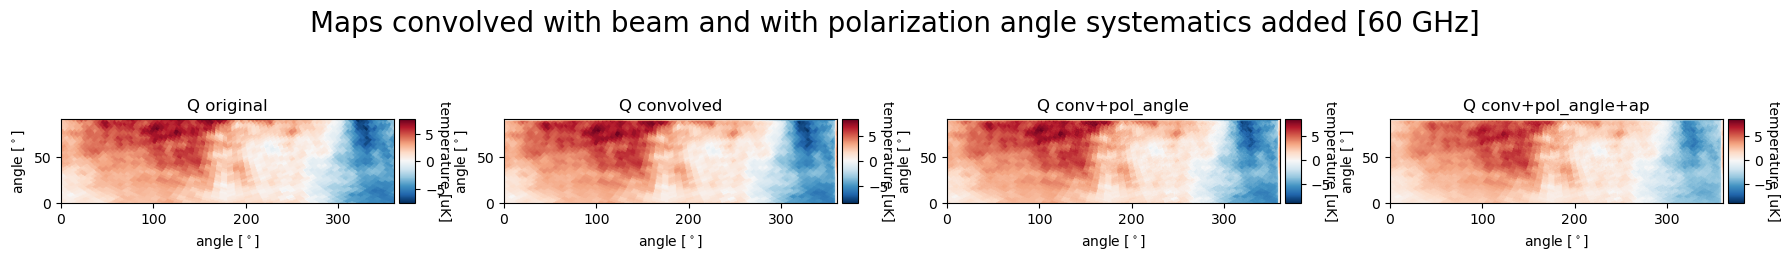

In [124]:
# POLARIZATION ANGLE
Q_polangle_40, U_polangle_40   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad)

Q_polangle_60, U_polangle_60   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad)
Q_polangle_78, U_polangle_78   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad)
Q_polangle_100, U_polangle_100 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad)
Q_polangle_140, U_polangle_140 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad)
Q_polangle_195, U_polangle_195 = polangle_map(Q_conv_real_195, U_conv_real_195, gauss_center, std_deviation_rad)
Q_polangle_280, U_polangle_280 = polangle_map(Q_conv_real_280, U_conv_real_280, gauss_center, std_deviation_rad)
Q_polangle_402, U_polangle_402 = polangle_map(Q_conv_real_402, U_conv_real_402, gauss_center, std_deviation_rad)

########################################################################################################

# APODIZATION
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /5, np.pi /5], y_range=[-np.pi /5, np.pi /5]))

Q_ap_40 = window * Q_polangle_40
U_ap_40 = window * U_polangle_40
I_ap_40 = window * I_conv_real_40

Q_ap_60 = window * Q_polangle_60
U_ap_60 = window * U_polangle_60
I_ap_60 = window * I_conv_real_60

Q_ap_78 = window * Q_polangle_78
U_ap_78 = window * U_polangle_78
I_ap_78 = window * I_conv_real_78

Q_ap_100 = window * Q_polangle_100
U_ap_100 = window * U_polangle_100
I_ap_100 = window * I_conv_real_100

Q_ap_140 = window * Q_polangle_140
U_ap_140 = window * U_polangle_140
I_ap_140 = window * I_conv_real_140

Q_ap_195 = window * Q_polangle_195
U_ap_195 = window * U_polangle_195
I_ap_195 = window * I_conv_real_195

Q_ap_280 = window * Q_polangle_280
U_ap_280 = window * U_polangle_280
I_ap_280 = window * I_conv_real_280

Q_ap_402 = window * Q_polangle_402
U_ap_402 = window * U_polangle_402
I_ap_402 = window * I_conv_real_402

########################################################################################################

# plot
Map_to_Plot = [output_vars['mp_hp_Q40'], Q_conv_real_40, Q_polangle_40, Q_ap_40]
title = ["Q original","Q convolved","Q conv+pol_angle", "Q conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[2])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[2])]

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolved with beam and with polarization angle systematics added [60 GHz]', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


# Component Separation

In [125]:
flatten_maps = {}
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)

for band in bands:
    for map_type in types:
        map_name = f"{map_type}_ap_{band}"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}_ap_{band}"
        
        new_map = np.zeros_like(I40)
        new_map[idx] = map_data.flatten()
        
        flatten_maps[f"{map_type}_flat{band}"] = new_map
        #print(f"Stored variables for: {variable_prefix}") 

flatten_maps.keys()

dict_keys(['I_flat40', 'Q_flat40', 'U_flat40', 'I_flat60', 'Q_flat60', 'U_flat60', 'I_flat78', 'Q_flat78', 'U_flat78', 'I_flat100', 'Q_flat100', 'U_flat100', 'I_flat140', 'Q_flat140', 'U_flat140', 'I_flat195', 'Q_flat195', 'U_flat195', 'I_flat280', 'Q_flat280', 'U_flat280', 'I_flat402', 'Q_flat402', 'U_flat402'])

In [126]:
np.shape(flatten_maps['I_flat40'])

(49152,)

In [127]:
freq40 = np.stack([flatten_maps['I_flat40'], flatten_maps['Q_flat40'], flatten_maps['U_flat40']])
freq60 = np.stack([flatten_maps['I_flat60'], flatten_maps['Q_flat60'], flatten_maps['U_flat60']])
freq78 = np.stack([flatten_maps['I_flat78'], flatten_maps['Q_flat78'], flatten_maps['U_flat78']])
freq100 = np.stack([flatten_maps['I_flat100'], flatten_maps['Q_flat100'], flatten_maps['U_flat100']])
freq140 = np.stack([flatten_maps['I_flat140'], flatten_maps['Q_flat140'], flatten_maps['U_flat140']])
freq195 = np.stack([flatten_maps['I_flat195'], flatten_maps['Q_flat195'], flatten_maps['U_flat195']])
freq280 = np.stack([flatten_maps['I_flat280'], flatten_maps['Q_flat280'], flatten_maps['U_flat280']])
freq402 = np.stack([flatten_maps['I_flat402'], flatten_maps['Q_flat402'], flatten_maps['U_flat402']])


full_array = np.array([freq40, freq60, freq78, freq100, freq140, freq195, freq280, freq402])
np.shape(full_array)

(8, 3, 49152)

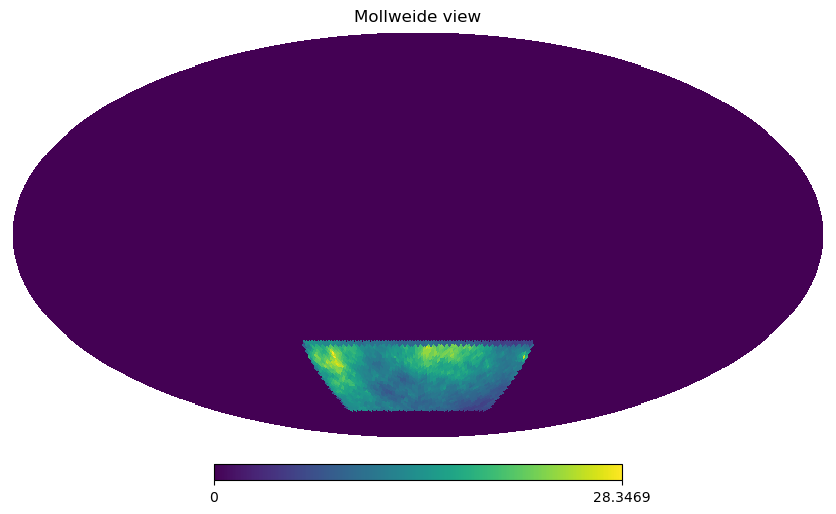

In [128]:
hp.mollview(full_array[0,0])

In [129]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch

freq

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
10,195.0,5.85,4.14,28.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
12,280.0,13.80,9.76,22.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
14,402.0,47.45,33.55,17.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


In [130]:
components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result = basic_comp_sep(components, freq, full_array)

print(result.params)
print(result.x)

cmb_I  = result.s[0,0]
cmb_Q  = result.s[0,1]
cmb_U  = result.s[0,2]

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.31495913 35.46415727 -2.49627094]


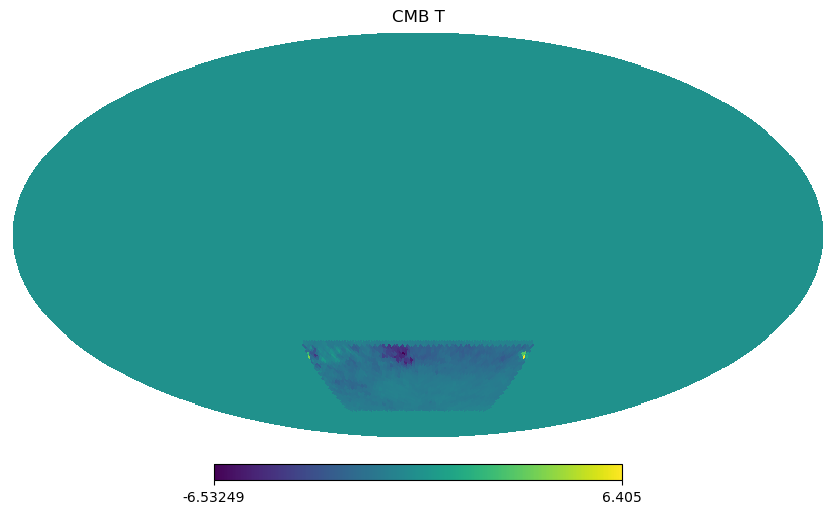

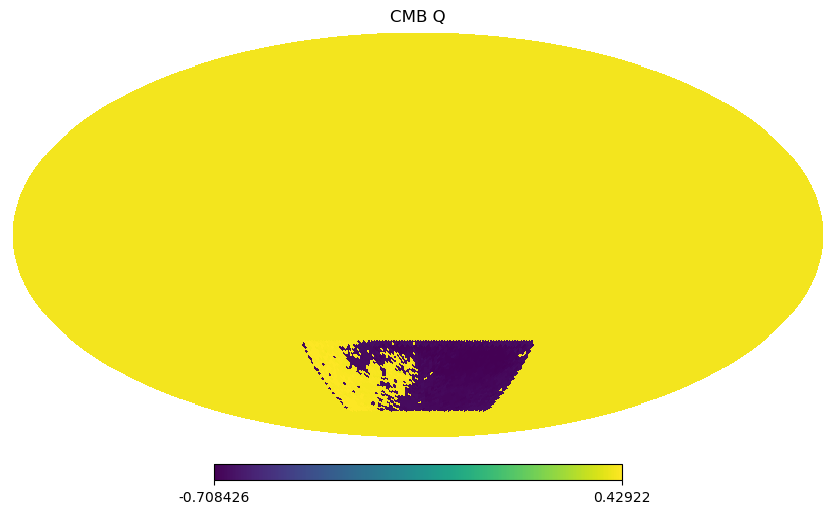

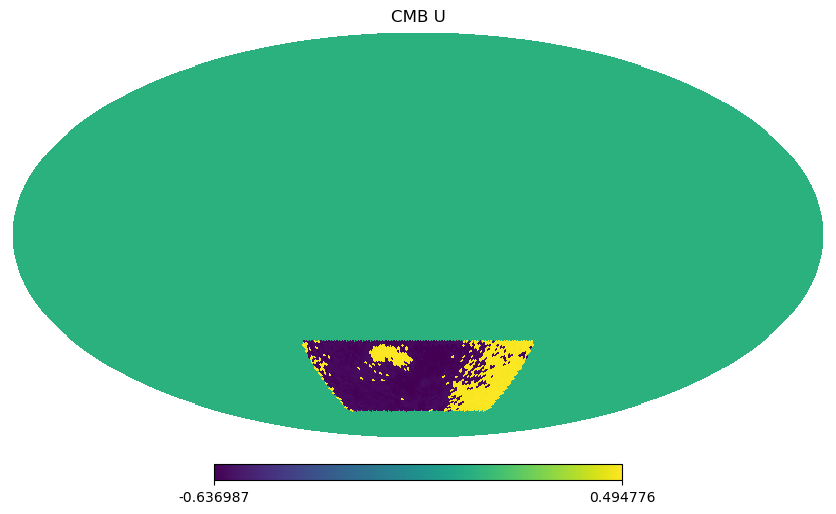

In [131]:
hp.mollview(cmb_I, title='CMB T')
hp.mollview(cmb_Q, title='CMB Q', norm='hist')
hp.mollview(cmb_U, title='CMB U', norm='hist')

# Deconvolution

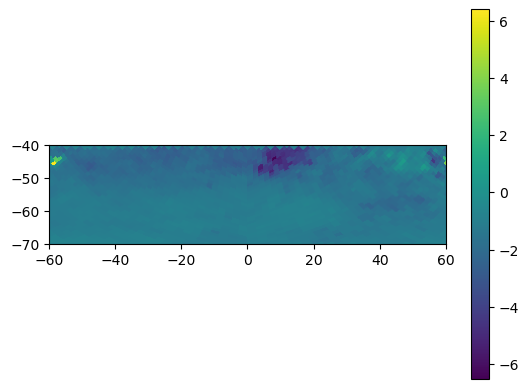

In [132]:
# torno in 2D
#idxs, resol = create_rectangular_patch([RA1, RA2], [DEC1, DEC2], nside)

cmb_I_2d, ra_hp, dec_hp = convert2grid(cmb_I, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d, ra_hp, dec_hp = convert2grid(cmb_Q, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d, ra_hp, dec_hp = convert2grid(cmb_U, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

plt.figure()
plt.imshow(cmb_I_2d,origin='lower', extent=extent)
plt.colorbar()

In [133]:
# ho cambiato la funzione di deconvoluzione perchè correct_lr_r non funziona, la mappa in input e quella in output sono uguali
I_deconv = deconvolve_map(cmb_I_2d, beam_x, perf_beam)
Q_deconv = deconvolve_map(cmb_Q_2d, beam_x, perf_beam)
U_deconv = deconvolve_map(cmb_U_2d, beam_x, perf_beam)

In [134]:
# convoluzione con beam perfetto
I_conv_perf = convolve_map_with_beam(cmb_I_2d, perf_beam)
Q_conv_perf = convolve_map_with_beam(cmb_Q_2d, perf_beam)
U_conv_perf = convolve_map_with_beam(cmb_U_2d, perf_beam)

# DIFFERENCE
I_diff = (I_conv_perf- I_deconv)
Q_diff = (Q_conv_perf- Q_deconv)
U_diff = (U_conv_perf- U_deconv)

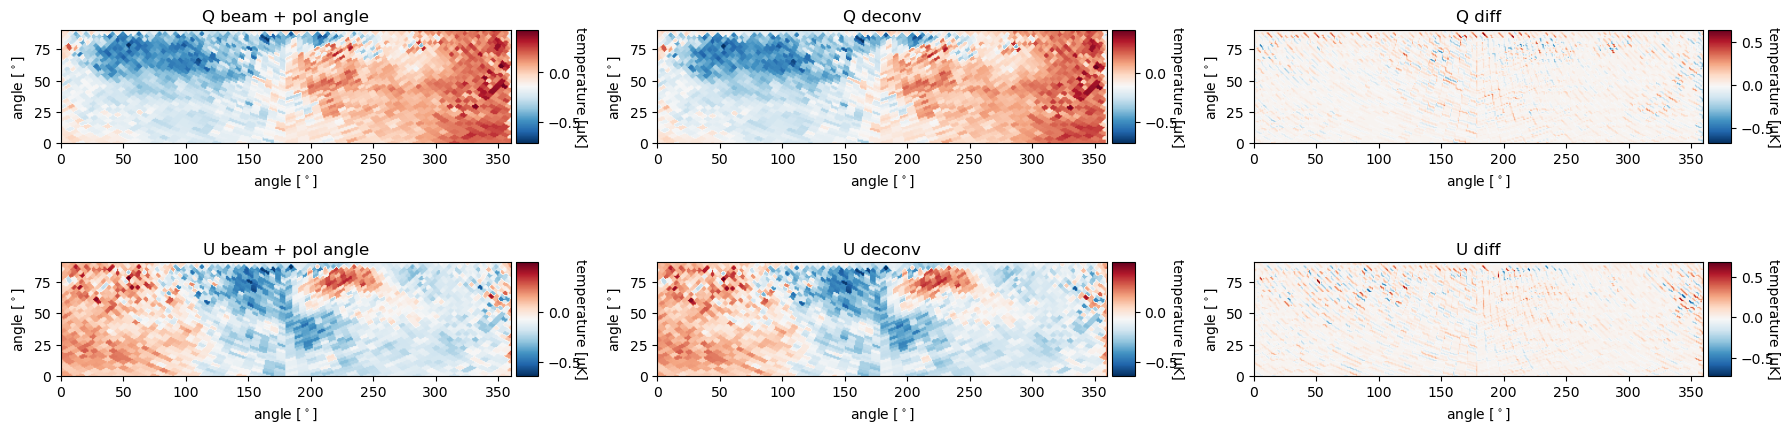

In [135]:
Map_to_Plot = [cmb_Q_2d,Q_deconv, Q_diff, cmb_U_2d ,U_deconv, U_diff]
title = ["Q beam + pol angle", "Q deconv", "Q diff", "U beam + pol angle", "U deconv", "U diff"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]



fig, axs = plt.subplots(2, 3, figsize=(18, 5))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
plt.show()


# Power spectra with NaMaster

In [136]:
import pymaster as nmt

In [137]:
pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(Q_deconv)

# Fields:
f0 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I_deconv])
f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q_deconv, U_deconv], purify_b=True)

# Bins:
l0_bins = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

In [138]:
# workspace
w00 = nmt.NmtWorkspaceFlat()
w02 = nmt.NmtWorkspaceFlat()
w22 = nmt.NmtWorkspaceFlat()

#w00.read_from("w00_flat.fits")
#w02.read_from("w02_flat.fits")
#w22.read_from("w22_flat.fits")

In [139]:
w00.compute_coupling_matrix(f0, f0, b)
w02.compute_coupling_matrix(f0, f2, b)
w22.compute_coupling_matrix(f2, f2, b)

w00.write_to("w00_flat.fits")
w02.write_to("w02_flat.fits")
w22.write_to("w22_flat.fits")

In [140]:
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
#cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
#cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
#cl22_uncoupled = w22.decouple_cell(cl22_coupled)

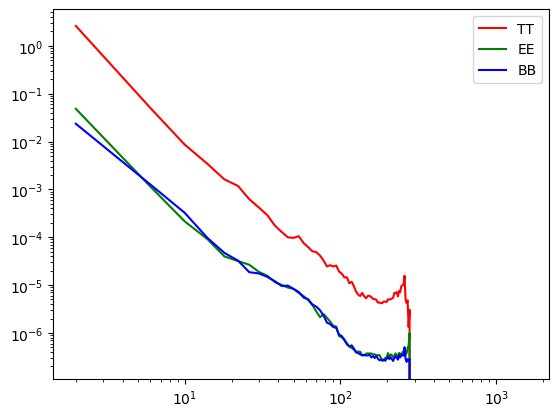

In [141]:
plt.figure()
#plt.plot(l, cl_tt, 'r-', label='Input TT')
#plt.plot(l, cl_ee, 'g-', label='Input EE')
#plt.plot(l, cl_bb, 'b-', label='Input BB')
plt.plot(ells_uncoupled, cl00_coupled[0], 'r', label='TT')
plt.plot(ells_uncoupled, cl22_coupled[0], 'g', label='EE')
plt.plot(ells_uncoupled, cl22_coupled[3], 'b', label='BB')
plt.loglog()
plt.legend()
plt.show()

Questi sono gli spettri delle mappe di sola CMB dopo la deconvoluzione, qunidi alla fine dell'analisi

# Confronto Ps
Confronto i PS ottenuti alla fine dell'analisi con
- quelli della patch originale (quindi senza nessuna sistematica) (ma devo prima fare la comonent separation per avere la cmb)
- quelli della patch con beam+angl+ap prima della deconvoluzione (ho già la cmb)
- quelli dei side lobes

### PS patch originale
Mi servono solo 3 mappe I, Q, U e di sola cmb, quindi faccio la component separation sulle mappe (già in 1d) chiamate I40, Q_40 etc
- component separation
- trasformo in 2d
- PS

In [142]:
freq40_or = np.stack([I40, Q40, U40])
freq60_or = np.stack([I60, Q60, U60])
freq78_or = np.stack([I78, Q78, U78])
freq100_or = np.stack([I100, Q100, U100])
freq140_or = np.stack([I140, Q140, U140])
freq195_or = np.stack([I195, Q195, U195])
freq280_or = np.stack([I280, Q280, U280])
freq402_or = np.stack([I402, Q402, U402])


full_array_or = np.array([freq40_or, freq60_or, freq78_or, freq100_or, freq140_or, freq195_or, freq280_or, freq402_or])
np.shape(full_array_or)


#################################################################
components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result_or = basic_comp_sep(components, freq, full_array_or)

print(result_or.params)
print(result_or.x)

cmb_I_or  = result_or.s[0,0]
cmb_Q_or  = result_or.s[0,1]
cmb_U_or  = result_or.s[0,2]

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.25821916 41.33251507 -2.33280128]


In [143]:
cmb_I_2d_or, _, _ = convert2grid(cmb_I_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_or, _, _ = convert2grid(cmb_Q_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_or, _, _ = convert2grid(cmb_U_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

<Figure size 640x480 with 0 Axes>

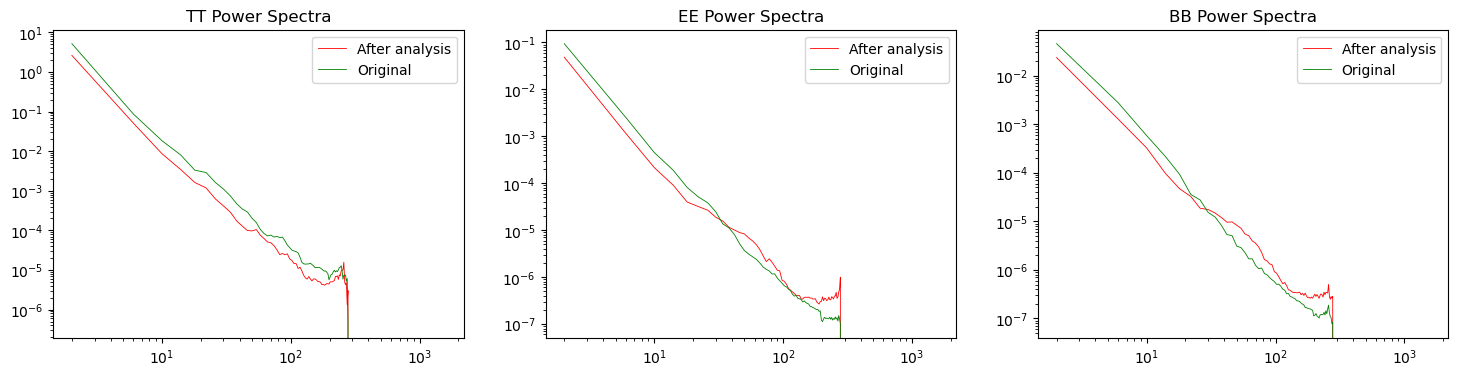

In [144]:
# Masks:
mask_or = np.ones_like(cmb_Q_2d_or)

# Fields:
f0_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_or])
f2_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_or, cmb_U_2d_or], purify_b=True)

# Bins:
l0_bins_or = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins_or = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b_or = nmt.NmtBinFlat(l0_bins_or, lf_bins_or)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled_or = b_or.get_effective_ells()

##############################################################################################################
# workspace
w00_or = nmt.NmtWorkspaceFlat()
w02_or = nmt.NmtWorkspaceFlat()
w22_or = nmt.NmtWorkspaceFlat()

w00_or.compute_coupling_matrix(f0_or, f0_or, b_or)
w02_or.compute_coupling_matrix(f0_or, f2_or, b_or)
w22_or.compute_coupling_matrix(f2_or, f2_or, b_or)


cl00_coupled_or = nmt.compute_coupled_cell_flat(f0_or, f0_or, b_or)
#cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled_or = nmt.compute_coupled_cell_flat(f0_or, f2_or, b_or)
#cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled_or = nmt.compute_coupled_cell_flat(f2_or, f2_or, b_or)
#cl22_uncoupled = w22.decouple_cell(cl22_coupled)

########################################################################################

plt.figure()
fig, ax = plt.subplots(1,3, figsize = (18,4))

# TT
ax[0].set_title('TT Power Spectra')
ax[0].plot(ells_uncoupled, cl00_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[0].plot(ells_uncoupled_or, cl00_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[0].loglog()
ax[0].legend()

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ells_uncoupled, cl22_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[1].loglog()
ax[1].legend()

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ells_uncoupled, cl22_coupled[3], 'r', label='After analysis', linewidth=0.6)
ax[2].plot(ells_uncoupled_or, cl22_coupled_or[3], 'g', label='Original', linewidth=0.6)
ax[2].loglog()
ax[2].legend()


plt.show()

### PS mappe con sistematiche prima della deconvoluzione
Per vedere che effetto ha. Ho già le mappe di sola cmb in 2d (cmb_I_2d...)

<Figure size 640x480 with 0 Axes>

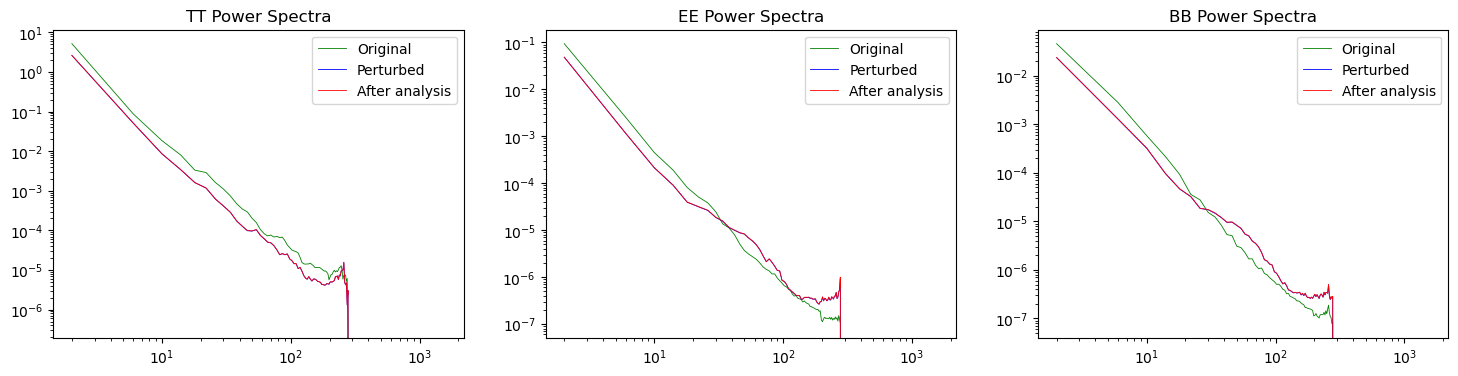

In [145]:
# Masks:
mask_pert = np.ones_like(cmb_Q_2d)

# Fields:
f0_pert = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d])
f2_pert = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d, cmb_U_2d], purify_b=True)

# Bins:
l0_bins_pert = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins_pert = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b_pert = nmt.NmtBinFlat(l0_bins_pert, lf_bins_pert)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled_pert = b_pert.get_effective_ells()

##############################################################################################################
# workspace
w00_pert = nmt.NmtWorkspaceFlat()
w02_pert = nmt.NmtWorkspaceFlat()
w22_pert = nmt.NmtWorkspaceFlat()

w00_pert.compute_coupling_matrix(f0_pert, f0_pert, b_pert)
w02_pert.compute_coupling_matrix(f0_pert, f2_pert, b_pert)
w22_pert.compute_coupling_matrix(f2_pert, f2_pert, b_pert)


cl00_coupled_pert = nmt.compute_coupled_cell_flat(f0_pert, f0_pert, b_pert)
#cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled_pert = nmt.compute_coupled_cell_flat(f0_pert, f2_pert, b_pert)
#cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled_pert = nmt.compute_coupled_cell_flat(f2_pert, f2_pert, b_pert)
#cl22_uncoupled = w22.decouple_cell(cl22_coupled)

########################################################################################

plt.figure()
fig, ax = plt.subplots(1,3, figsize = (18,4))

# TT
ax[0].set_title('TT Power Spectra')
ax[0].plot(ells_uncoupled_or, cl00_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[0].plot(ells_uncoupled_pert, cl00_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl00_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[0].loglog()
ax[0].legend()

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[1].plot(ells_uncoupled_pert, cl22_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[1].loglog()
ax[1].legend()

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ells_uncoupled_or, cl22_coupled_or[3], 'g', label='Original', linewidth=0.6)
ax[2].plot(ells_uncoupled_pert, cl22_coupled_pert[3], 'b', label='Perturbed', linewidth=0.6)
ax[2].plot(ells_uncoupled, cl22_coupled[3], 'r', label='After analysis', linewidth=0.6)
ax[2].loglog()
ax[2].legend()


plt.show()

Dovrebbero essere gli spettri di
- mappa originale, senza sistematiche (Original)
- mappa perturbata (con beam + angolo di pol + apo) (Perturbed)
- mappa dopo l'analisi (quindi quella perturbata ma deconvoluta) (After Analysis)
Perturbed e After analysis sono simili ma diverse (sotto lo zoom)

<Figure size 640x480 with 0 Axes>

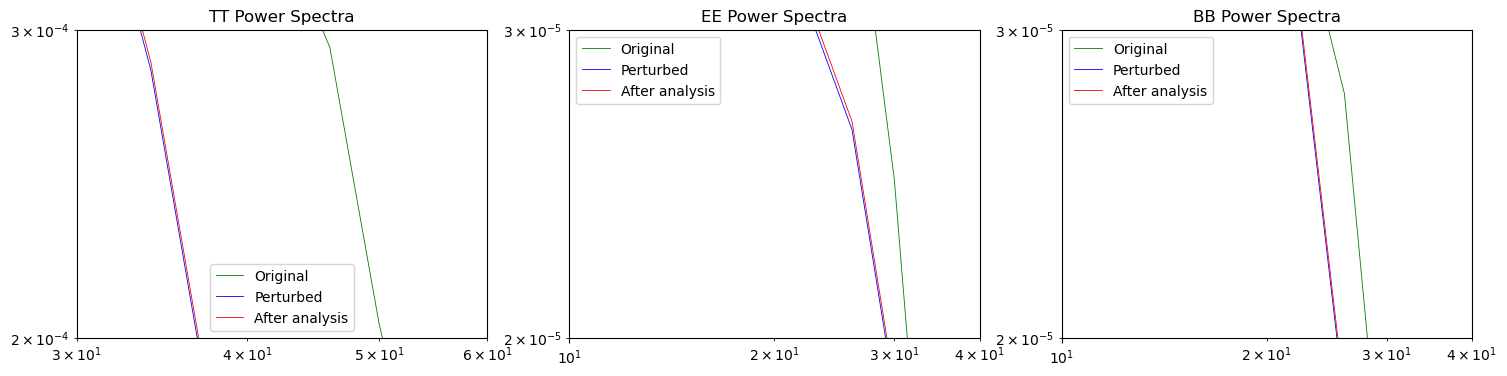

In [146]:
plt.figure()
fig, ax = plt.subplots(1,3, figsize = (18,4))

# TT
ax[0].set_title('TT Power Spectra')
ax[0].plot(ells_uncoupled_or, cl00_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[0].plot(ells_uncoupled_pert, cl00_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl00_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[0].loglog()
ax[0].legend()
ax[0].set_ylim(2*10e-5,3*10e-5)
ax[0].set_xlim(30, 60)

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[1].plot(ells_uncoupled_pert, cl22_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[1].loglog()
ax[1].legend()
ax[1].set_ylim(2*10e-6,3*10e-6)
ax[1].set_xlim(10, 40)

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ells_uncoupled_or, cl22_coupled_or[3], 'g', label='Original', linewidth=0.6)
ax[2].plot(ells_uncoupled_pert, cl22_coupled_pert[3], 'b', label='Perturbed', linewidth=0.6)
ax[2].plot(ells_uncoupled, cl22_coupled[3], 'r', label='After analysis', linewidth=0.6)
ax[2].loglog()
ax[2].legend()
ax[2].set_ylim(2*10e-6,3*10e-6)
ax[2].set_xlim(10, 40)


plt.show()

### Side lobes PS

<Figure size 640x480 with 0 Axes>

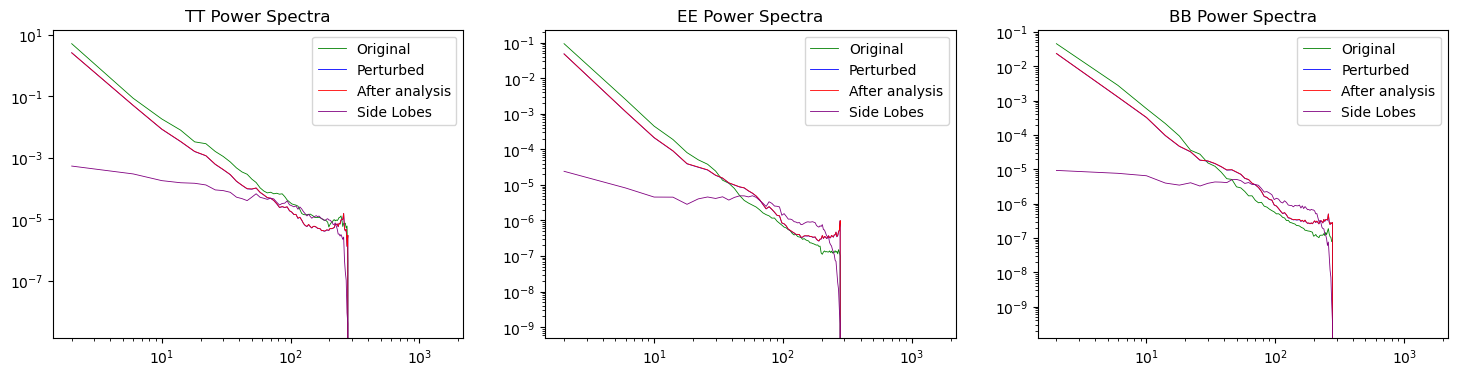

In [147]:
# Masks:
mask_diff = np.ones_like(I_diff)

# Fields:
f0_diff = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I_diff])
f2_diff = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q_diff, U_diff], purify_b=True)

# Bins:
l0_bins_diff = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins_diff = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b_diff = nmt.NmtBinFlat(l0_bins_diff, lf_bins_diff)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled_diff = b_diff.get_effective_ells()

##############################################################################################################
# workspace
w00_diff = nmt.NmtWorkspaceFlat()
w02_diff = nmt.NmtWorkspaceFlat()
w22_diff = nmt.NmtWorkspaceFlat()

w00_diff.compute_coupling_matrix(f0_diff, f0_diff, b_diff)
w02_diff.compute_coupling_matrix(f0_diff, f2_diff, b_diff)
w22_diff.compute_coupling_matrix(f2_diff, f2_diff, b_diff)


cl00_coupled_diff = nmt.compute_coupled_cell_flat(f0_diff, f0_diff, b_diff)
#cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled_diff = nmt.compute_coupled_cell_flat(f0_diff, f2_diff, b_diff)
#cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled_diff = nmt.compute_coupled_cell_flat(f2_diff, f2_diff, b_diff)
#cl22_uncoupled = w22.decouple_cell(cl22_coupled)

########################################################################################

plt.figure()
fig, ax = plt.subplots(1,3, figsize = (18,4))

# TT
ax[0].set_title('TT Power Spectra')
ax[0].plot(ells_uncoupled_or, cl00_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[0].plot(ells_uncoupled_pert, cl00_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl00_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[0].plot(ells_uncoupled_diff, cl00_coupled_diff[0], color='purple', label='Side Lobes', linewidth=0.6)

ax[0].loglog()
ax[0].legend()

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[0], 'g', label='Original', linewidth=0.6)
ax[1].plot(ells_uncoupled_pert, cl22_coupled_pert[0], 'b', label='Perturbed', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled[0], 'r', label='After analysis', linewidth=0.6)
ax[1].plot(ells_uncoupled_diff, cl22_coupled_diff[0], color='purple', label='Side Lobes', linewidth=0.6)

ax[1].loglog()
ax[1].legend()

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ells_uncoupled_or, cl22_coupled_or[3], 'g', label='Original', linewidth=0.6)
ax[2].plot(ells_uncoupled_pert, cl22_coupled_pert[3], 'b', label='Perturbed', linewidth=0.6)
ax[2].plot(ells_uncoupled, cl22_coupled[3], 'r', label='After analysis', linewidth=0.6)
ax[2].plot(ells_uncoupled_diff, cl22_coupled_diff[3], color='purple', label='Side Lobes', linewidth=0.6)

ax[2].loglog()
ax[2].legend()


plt.show()